In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import train_test_split
import random
from keras.models import clone_model
import copy
from google.colab import drive
import tarfile
import pandas as pd
from datetime import datetime, timedelta
import pickle
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import networkx as nx
import random
from collections import deque
import statistics
import time


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 1: Import required libraries
from keras import backend as K

# Step 2: Configure TensorFlow to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
K.set_session(session)

In [2]:
# with open('/content/drive/MyDrive/Colab Notebooks/Thesis/UK power networks dataset/df_acorn_e.pkl', 'rb') as file:
#     df_acorn_e= pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/Thesis/UK power networks dataset/df_cluster_4.pkl', 'rb') as file:
    df_cluster_4= pickle.load(file)

# with open('/content/drive/MyDrive/Colab Notebooks/Thesis/UK power networks dataset/df_processing2.pkl', 'rb') as file:
#     df_processing2= pickle.load(file)

In [ ]:
# selecting random num_clients out of total cleints (643 for acorn-e and 298 for cluster_4)
df_data = df_cluster_4
# df_data = df_processing2
random.seed(3)
num_clients = 32
sampled_ids = random.sample(df_data.LCLid.unique().tolist(),num_clients)
sampled_ids.sort()

In [ ]:
# # K-MEANS CLUSTERING
# # Import necessary libraries
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# import imblearn
# from imblearn.ensemble import BalancedRandomForestClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.tree import plot_tree
# # FEATURE VECTOR CONSTRUCTION
# df = df_cluster_4

# def iqr(x):
#     return x.quantile(0.75) - x.quantile(0.25)

# # df_k_means = df[['LCLid','load']].groupby(['LCLid']).agg(['mean','median','max','min','std',iqr,'sum',lambda x: x.max() - x.min()])
# # df_k_means = df[['LCLid','load']].groupby(['LCLid']).agg(['mean','median','std',iqr,lambda x: x.max() - x.min()])
# df_k_means = df[['LCLid','load']].groupby(['LCLid']).agg(['mean','median','std',iqr])


# df_k_means = df_k_means.droplevel(level=0, axis=1)

# grouped_df = df.groupby(['LCLid', 'Weekday'])['load'].mean().reset_index()
# min_load_indexes = grouped_df.groupby('LCLid')['load'].idxmin()
# max_load_indexes = grouped_df.groupby('LCLid')['load'].idxmax()

# min_load_df = grouped_df.loc[min_load_indexes]
# max_load_df = grouped_df.loc[max_load_indexes]

# min_load_df = min_load_df.rename(columns={'Weekday': 'Weekday_min'})
# max_load_df = max_load_df.rename(columns={'Weekday': 'Weekday_max'})

# result_df = pd.merge(min_load_df[['LCLid', 'Weekday_min']],
#                     max_load_df[['LCLid', 'Weekday_max']],
#                     on='LCLid')

# # df_k_means = pd.merge(df_k_means, result_df, on='LCLid')
# # df_k_means = pd.merge(df_k_means, df[['LCLid','id']].drop_duplicates(), on='LCLid')
# df_k_means.rename(columns={'<lambda_0>': 'range'}, inplace=True)

# from sklearn.cluster import KMeans
# data_for_clustering = df_k_means[df_k_means.columns[1:-1]].values
# num_clusters = 10
# kmeans = KMeans(n_clusters=num_clusters, random_state=0)
# cluster_labels = kmeans.fit_predict(data_for_clustering)
# df_k_means['cluster_label'] = cluster_labels
# df_k_means = df_k_means.reset_index()
# df_k_means.head(2)

In [ ]:
# df_k_means.groupby(['cluster_label']).count()

In [ ]:
# sampled_ids = df_k_means[df_k_means.cluster_label==5]['LCLid'].unique()
# num_clients = len(sampled_ids)

In [ ]:
df = df_data[df_data.LCLid.isin(set(sampled_ids))].sort_values(['LCLid','DateTime']).reset_index(drop = True)

In [ ]:
df.head()

,LCLid,stdorToU,DateTime,load,Acorn,Weekday,Hour,apparentTemperature,AVG4D,TempCluster
0,MAC000179,Std,2013-01-01 00:00:00,0.180,ACORN-E,1,0,3.66,0.180,0
1,MAC000179,Std,2013-01-01 01:00:00,0.132,ACORN-E,1,1,4.24,0.132,0
2,MAC000179,Std,2013-01-01 02:00:00,0.184,ACORN-E,1,2,3.74,0.184,0
3,MAC000179,Std,2013-01-01 03:00:00,0.136,ACORN-E,1,3,3.89,0.136,0
4,MAC000179,Std,2013-01-01 04:00:00,0.158,ACORN-E,1,4,3.34,0.158,0


In [ ]:
df['Acorn_codes'] = df.Acorn.astype('category').cat.codes

In [ ]:
# Create a dictionary to map LCLid to integer
lclid_map = {lclid: i for i, lclid in enumerate(sampled_ids)}

# Create the 'id' column using the mapping
df['id'] = df['LCLid'].map(lclid_map)

df.head()

,LCLid,stdorToU,DateTime,load,Acorn,Weekday,Hour,apparentTemperature,AVG4D,TempCluster,Acorn_codes,id
0,MAC000179,Std,2013-01-01 00:00:00,0.180,ACORN-E,1,0,3.66,0.180,0,2,0
1,MAC000179,Std,2013-01-01 01:00:00,0.132,ACORN-E,1,1,4.24,0.132,0,2,0
2,MAC000179,Std,2013-01-01 02:00:00,0.184,ACORN-E,1,2,3.74,0.184,0,2,0
3,MAC000179,Std,2013-01-01 03:00:00,0.136,ACORN-E,1,3,3.89,0.136,0,2,0
4,MAC000179,Std,2013-01-01 04:00:00,0.158,ACORN-E,1,4,3.34,0.158,0,2,0


In [ ]:
non_benefitting_clients = {}
non_benefitting_clients[0]=[ 27, 20, 7, 10, 0, 16, 15, 24]
non_benefitting_clients[1]=[ 1,31,15,11,3,27,4,25]
non_benefitting_clients[2]=[ 31,22,19,24]
non_benefitting_clients[3]=[ 19,17,31,3]
non_benefitting_clients[4]=[ 26,30,18,0,1,16,29]
non_benefitting_clients[5]=[ 19,0,15,26,4,21,10]
non_benefitting_clients[6]=[27,0,5,26,9,10,7,19,24]
non_benefitting_clients[7]=[21,1,27,2]

In [ ]:
#REMOVING THE NON-BENEFITTING CLIENTS
# df = df[~df.id.isin(non_benefitting_clients[2])].sort_values(['LCLid','DateTime']).reset_index(drop = True)
# # Create a dictionary to map LCLid to integer
# lclid_map = {lclid: i for i, lclid in enumerate(sorted(list(set(df.LCLid))))}

# # Create the 'id' column using the mapping
# df['id'] = df['LCLid'].map(lclid_map)

# df.head()

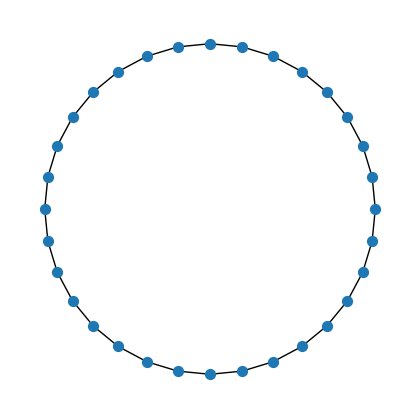

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

# Set k (nearest neighbors), and probability of rewiring
k = 4
p = 0.3
num_clients = 32
# Create a Watts-Strogatz graph and complete graph
ws_graph = nx.watts_strogatz_graph(num_clients, k, p,0)
complete_graph = nx.complete_graph(num_clients)

m = 3
ba_graph = nx.barabasi_albert_graph(num_clients, m,0)


# random.shuffle(sampled_ids)
ring_graph = nx.cycle_graph(num_clients)


# Arrange nodes in a circular layout
# pos = nx.circular_layout(ws_graph)

# Draw the graph with circular layout
# nx.draw(ws_graph, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')

# Display the plot
# plt.title("Watts-Strogatz Graph (Circular Layout)")
# plt.show()


# Draw the graph in a circular layout
plt.figure(figsize=(4, 4))
pos = nx.circular_layout(ring_graph)
nx.draw(ring_graph, pos, with_labels=False, node_size=50)
plt.show()


In [8]:
r = np.linalg.eigvals(nx.laplacian_matrix(ring_graph).toarray())
r.sort()
r

array([4.85722573e-17, 3.84294392e-02, 3.84294392e-02, 1.52240935e-01,
       1.52240935e-01, 3.37060775e-01, 3.37060775e-01, 5.85786438e-01,
       5.85786438e-01, 8.88859534e-01, 8.88859534e-01, 1.23463314e+00,
       1.23463314e+00, 1.60981936e+00, 1.60981936e+00, 2.00000000e+00,
       2.00000000e+00, 2.39018064e+00, 2.39018064e+00, 2.76536686e+00,
       2.76536686e+00, 3.11114047e+00, 3.11114047e+00, 3.41421356e+00,
       3.41421356e+00, 3.66293922e+00, 3.66293922e+00, 3.84775907e+00,
       3.84775907e+00, 3.96157056e+00, 3.96157056e+00, 4.00000000e+00])

In [9]:
ba = np.linalg.eigvals(nx.laplacian_matrix(ba_graph).toarray())
ba.sort()
ba

array([9.62647853e-16, 9.48678505e-01, 1.72500272e+00, 1.96062341e+00,
       2.08510773e+00, 2.21916818e+00, 2.34051469e+00, 2.44556963e+00,
       2.48887059e+00, 2.66829390e+00, 2.70315216e+00, 2.78978303e+00,
       2.89375631e+00, 2.97362098e+00, 2.97991189e+00, 2.99206601e+00,
       3.41070502e+00, 4.27192290e+00, 4.71951911e+00, 5.34454461e+00,
       5.57228911e+00, 6.12445709e+00, 6.37826262e+00, 7.40511298e+00,
       7.85192439e+00, 8.23448508e+00, 9.57170769e+00, 1.07320408e+01,
       1.11749439e+01, 1.47027013e+01, 1.55828739e+01, 1.67083898e+01])

In [10]:
ws = np.linalg.eigvals(nx.laplacian_matrix(ws_graph).toarray())
ws.sort()
ws

array([-4.44089210e-16,  4.54041447e-01,  7.13163634e-01,  9.27714271e-01,
        1.43359603e+00,  1.48054209e+00,  1.73223542e+00,  2.16588719e+00,
        2.44398893e+00,  2.54712695e+00,  2.79196691e+00,  3.44088831e+00,
        3.48273251e+00,  3.58889844e+00,  4.15601712e+00,  4.17226382e+00,
        4.30643199e+00,  4.45000957e+00,  4.63471114e+00,  4.82889375e+00,
        5.14064477e+00,  5.29541512e+00,  5.39599616e+00,  5.56306163e+00,
        5.72753762e+00,  6.21192210e+00,  6.24921968e+00,  6.64194001e+00,
        6.76499020e+00,  6.90291845e+00,  7.11201429e+00,  7.24323045e+00])

In [11]:
cg = np.linalg.eigvals(nx.laplacian_matrix(complete_graph).toarray())
cg.sort()
cg

array([3.55271368e-15, 3.20000000e+01, 3.20000000e+01, 3.20000000e+01,
       3.20000000e+01, 3.20000000e+01, 3.20000000e+01, 3.20000000e+01,
       3.20000000e+01, 3.20000000e+01, 3.20000000e+01, 3.20000000e+01,
       3.20000000e+01, 3.20000000e+01, 3.20000000e+01, 3.20000000e+01,
       3.20000000e+01, 3.20000000e+01, 3.20000000e+01, 3.20000000e+01,
       3.20000000e+01, 3.20000000e+01, 3.20000000e+01, 3.20000000e+01,
       3.20000000e+01, 3.20000000e+01, 3.20000000e+01, 3.20000000e+01,
       3.20000000e+01, 3.20000000e+01, 3.20000000e+01, 3.20000000e+01])

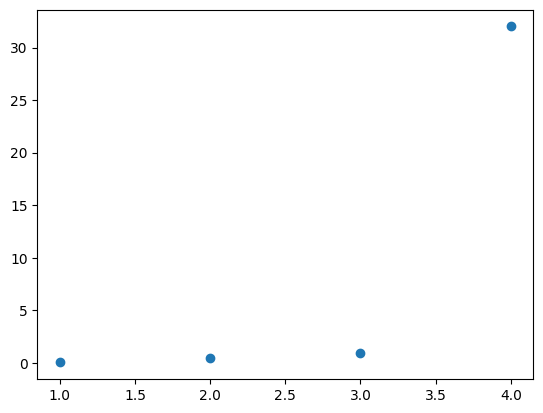

In [15]:
plt.scatter([1,2,3,4],[r[1],ws[1],ba[1],cg[1]])

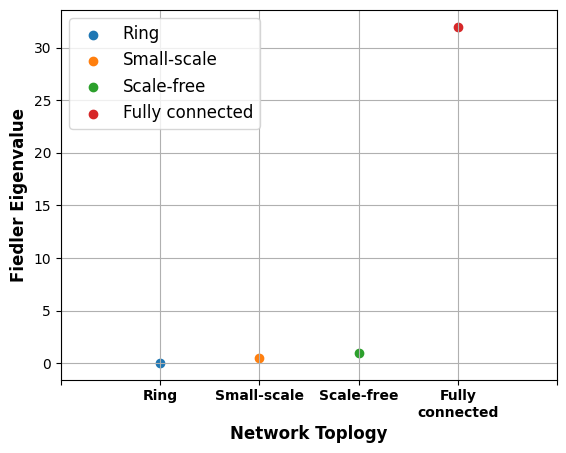

In [52]:


fig,ax = plt.subplots()

# ax.scatter([1 for i in range(len(r))],r)

# ax.scatter([2 for i in range(len(r))],ws)
# ax.scatter([3 for i in range(len(r))],ba)
# ax.scatter([4 for i in range(len(r))],cg)
ax.scatter([1],[r[1]])
ax.scatter([2],[ws[1]])
ax.scatter([3],[ba[1]])
ax.scatter([4],[cg[1]])
names = ['','Ring', 'Small-scale', 'Scale-free','Fully\nconnected','']
ax.set_xticks([i for i in range(6)])
ax.set_xticklabels([names[i] for i in [i for i in range(6)]], fontsize=10, fontweight='bold')
# ax.set_yticks([0.1,0.11,0.12,0.13,0.14,0.15])
# ax.set_yticklabels([str(i) for i in [0.1,0.11,0.12,0.13,0.14,0.15]], fontsize=10, fontweight='bold')

# Customize the x-axis label
ax.set_xlabel('Network Toplogy', fontsize=12, fontweight='bold')
ax.set_ylabel('Fiedler Eigenvalue', fontsize=12, fontweight='bold')
ax.grid()
ax.legend(names[1:-2]+['Fully connected'],fontsize = 12)

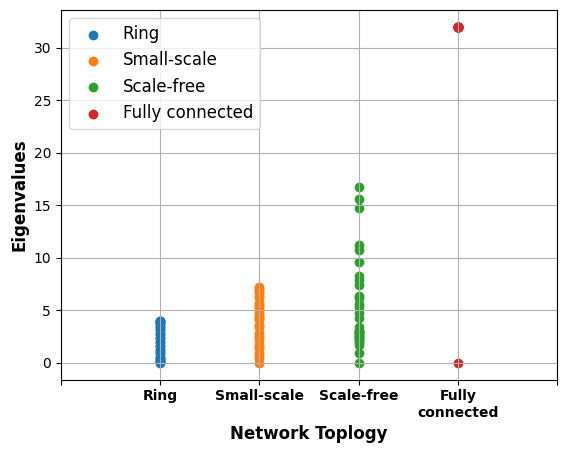

In [44]:
fig,ax = plt.subplots()

ax.scatter([1 for i in range(len(r))],r)

ax.scatter([2 for i in range(len(r))],ws)
ax.scatter([3 for i in range(len(r))],ba)
ax.scatter([4 for i in range(len(r))],cg)

names = ['','Ring', 'Small-scale', 'Scale-free','Fully\nconnected','']
ax.set_xticks([i for i in range(6)])
ax.set_xticklabels([names[i] for i in [i for i in range(6)]], fontsize=10, fontweight='bold')
# ax.set_yticks([0.1,0.11,0.12,0.13,0.14,0.15])
# ax.set_yticklabels([str(i) for i in [0.1,0.11,0.12,0.13,0.14,0.15]], fontsize=10, fontweight='bold')

# Customize the x-axis label
ax.set_xlabel('Network Toplogy', fontsize=12, fontweight='bold')
ax.set_ylabel('Eigenvalues', fontsize=12, fontweight='bold')
ax.grid()
ax.legend(names[1:-2]+['Fully connected'],fontsize = 12)

In [ ]:
def huber_loss(y_true, y_pred, delta=0.1):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    squared_loss = 0.5 * tf.square(error)
    linear_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, squared_loss, linear_loss)

def smape_loss(y_true, y_pred):
    numerator = tf.abs(y_true - y_pred)
    denominator = 0.5*(tf.abs(y_true) + tf.abs(y_pred))
    return tf.reduce_mean(numerator / denominator)



In [ ]:
#  main model
random.seed(0)
window = 24;
stride = 1;

main_model = Sequential()

main_model.add(LSTM(32, input_shape=(window,1), activation='tanh', return_sequences=True))
main_model.add(Dropout(0.1))

# model.add(BatchNormalization())
main_model.add(LSTM(16, activation='tanh', return_sequences=False))
main_model.add(Dropout(0.1))

# model.add(BatchNormalization())

main_model.add(Dense(1))

main_model.compile(optimizer='adam', loss=huber_loss, metrics=[keras.metrics.RootMeanSquaredError(),"mean_absolute_percentage_error"])


main_model_weights = main_model.get_weights()

In [ ]:
main_model_weights[0][0][0]

0.006765157

In [ ]:
#individual stuff
network = []
MAPE2 = []
for i in range(num_clients):
  print("id: ",i)
  columns = ['load','Weekday','Hour','AVG4D','TempCluster']
  x_data,  y_data = df_to_X_y(df[df.id==i].reset_index(drop=True),window,stride,'no_normalization',[],[],'No_Acorn')
  model = keras.models.clone_model(main_model)
  model.compile(optimizer=Adam(learning_rate = 0.0001), loss='mae', metrics=[keras.metrics.RootMeanSquaredError(),"mean_absolute_percentage_error",'mae'])
  model.set_weights(main_model_weights)
  client = Client(i, [], model, x_data, y_data)
  # monitoring_metric = 'val_mean_absolute_percentage_error'
  monitoring_metric = 'val_mae'
  early_stopping = EarlyStopping(monitor=monitoring_metric, min_delta=0.001, patience=3, mode='min')
  checkpoint = ModelCheckpoint('best_model.h5', monitor=monitoring_metric, save_best_only=True, mode='min')
  t1 = time.time()
  history = client.model.fit(client.x_train, client.y_train, batch_size = 100, epochs=50,validation_data = (client.x_val,client.y_val), verbose = 0,callbacks=[checkpoint,early_stopping]).history
  m = keras.models.load_model('best_model.h5')
  client.model.set_weights(m.get_weights())
  t1 = time.time()
  client.run_time = time.time()-t1
  for key, value in history.items():
            client.history[key] = client.history.get(key, []) + value
  MAPE2.append(client.model.evaluate(client.x_test,client.y_test,verbose = 0)[2])
  print("MAPE: ",client.model.evaluate(client.x_test,client.y_test,verbose = 0)[2])
  network.append(client)
server = Server(network,[])
# for saving and loading from pickle purposes
for client in server.network:
  client.model.compile(optimizer="adam", loss='mae', metrics=[keras.metrics.RootMeanSquaredError(),"mean_absolute_percentage_error",'mae'])


In [ ]:
# with open('/content/drive/MyDrive/Colab Notebooks/Thesis/UK power networks dataset/server_lossMAE_none_b100_f1_client_random_seed_12_monitor_mae', 'wb') as file:
#   pickle.dump(server, file)

In [ ]:
network = [];
graph = ws_graph
columns = ['load','Weekday','Hour','AVG4D','TempCluster']
mean_values = np.mean(df[columns].values, axis=(0,1), keepdims=True)
std_values = np.std(df[columns].values, axis=(0,1), keepdims=True)
min_values = np.min(df[columns].values, axis=(0,1), keepdims=True)
max_values = np.max(df[columns].values, axis=(0,1), keepdims=True)
for id in range(num_clients):
  print(id)
  x_data,  y_data = df_to_X_y(df[df.id==id].reset_index(drop=True),window,stride,'no_normalization',[],[],'No_Acorn')
  model = keras.models.clone_model(main_model)
  model.compile(optimizer=Adam(learning_rate = 0.0001), loss='mae', metrics=[keras.metrics.RootMeanSquaredError(),"mean_absolute_percentage_error",'mae'])
  model.set_weights(main_model_weights)
  client = Client(id, [i for i in graph.neighbors(id)], model, x_data, y_data)
  network.append(client)
server = Server(network,[])
t1 = time
t1 = time.time()
server.aggregation(50,100,5,10,'individual')
t2 = time.time()
run_time = t2-t1
server.run_time = run_time

# for saving and loading from pickle purposes
for client in server.network:
  client.model.compile(optimizer="adam", loss='mae', metrics=[keras.metrics.RootMeanSquaredError(),"mean_absolute_percentage_error",'mae'])

# central aggregated
# X = np.empty((0,window,1))
# Y = np.empty((0,))
# for i in range(num_clients):
#   x,y = df_to_X_y(df[df.id==i].reset_index(drop=True),window,stride,'no_normalization',[],[],'No_Acorn')
#   X = np.concatenate((X,x),axis=0)
#   Y = np.concatenate((Y,y),axis=0)
#   x_train_val, x_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.085, shuffle=False,random_state=0)
#   x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1, shuffle=False,random_state=0)
# monitoring_metric = 'val_loss'
# early_stopping = EarlyStopping(monitor=monitoring_metric, min_delta=0.001, patience=3, mode='min')
# checkpoint = ModelCheckpoint('best_model.h5', monitor=monitoring_metric, save_best_only=True, mode='min')
# overall_model = keras.models.clone_model(main_model)
# overall_model.set_weights = main_model.get_weights()
# overall_model.compile(optimizer=Adam(learning_rate = 0.0001), loss='mae', metrics=[keras.metrics.RootMeanSquaredError(),"mean_absolute_percentage_error",'mae'])
# t = time.time()
# history = overall_model.fit(x_train, y_train, batch_size = 100, epochs=50,validation_data = (x_val,y_val), verbose = 1,callbacks=[checkpoint]).history
# server.run_time = time.time()-t
# for client in server.network:
#   client.model.set_weights(overall_model.get_weights())

# # for saving and loading from pickle purposes
# for client in server.network:
#   client.model.compile(optimizer="adam", loss='mae', metrics=[keras.metrics.RootMeanSquaredError(),"mean_absolute_percentage_error",'mae'])



# Naive

# def move_elements_right(arr):
#     return np.concatenate((arr[:1], arr[:-1]))
# mae = []
# rmse = []
# mape = []
# for client in server.network:
#   y_true = client.y_test
#   y_pred = move_elements_right(y_true)
#   mae.append(np.mean(np.abs(y_pred-y_true)))
#   rmse.append(np.sqrt(np.mean((y_pred-y_true)**2)))
#   mape.append(np.mean(np.abs(y_true-y_pred/y_true))*100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
ROUND:  0
client:  0
client:  1
client:  2
client:  3
client:  4
client:  5
client:  6
client:  7
client:  8
client:  9
client:  10
client:  11
client:  12
client:  13
client:  14
client:  15
client:  16
client:  17
client:  18
client:  19
client:  20
client:  21
client:  22
client:  23
client:  24
client:  25
client:  26
client:  27
client:  28
client:  29
client:  30
client:  31
val_loss_list:  [0.1149590015411377]
val_mape:  41.64069747924805
val_loss_list:  [0.1234007254242897]
val_mape:  59.76176834106445
val_loss_list:  [0.07609686255455017]
val_mape:  36.9239387512207
val_loss_list:  [0.08248210698366165]
val_mape:  45.37470626831055
val_loss_list:  [0.16968810558319092]
val_mape:  131.0830841064453
val_loss_list:  [0.2221904695034027]
val_mape:  42.68376922607422
val_loss_list:  [0.1667652726173401]
val_mape:  72.82933044433594
val_loss_list:  [0.19265960156917572]
val_mape:  56.16805267333984

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Thesis/UK power networks dataset/server_lossMAE_c32_ws_graph_k4_p0.3_esI_none_b100_f1_client_random_seed_3_monitor_mae', 'wb') as file:
# with open('/content/drive/MyDrive/Colab Notebooks/Thesis/UK power networks dataset/server_lossMAE_c32_ba_graph_m3_esI_none_b100_f1_client_random_seed_4_monitor_mae', 'wb') as file:
# with open('/content/drive/MyDrive/Colab Notebooks/Thesis/UK power networks dataset/server_lossMAE_c32_fullconnect_esI_none_b100_f1_client_random_seed_6_monitor_mae', 'wb') as file:
# with open('/content/drive/MyDrive/Colab Notebooks/Thesis/UK power networks dataset/server_lossMAE_c32_ring_graph_esI_none_b100_f1_client_random_seed_7_monitor_mae', 'wb') as file:
# with open('/content/drive/MyDrive/Colab Notebooks/Thesis/UK power networks dataset/server_lossMAE_overall_none_b100_f1__client_random_seed_6_monitor_mae', 'wb') as file:
  pickle.dump(server, file)

In [ ]:
server.run_time/60

29.07711777687073

In [ ]:

RMSE = []
MAPE = []
MAE = []
for idx in range(num_clients):
  print(idx)
  client = server.network[idx]
  # y_true = client.y_test
  # y_pred = client.model.predict(client.x_test).T[0]
  client.model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError(),"mean_absolute_percentage_error"])
  MAE.append(client.model.evaluate(client.x_test,client.y_test,verbose = 0)[0])
  RMSE.append(client.model.evaluate(client.x_test,client.y_test,verbose = 0)[1])
  MAPE.append(client.model.evaluate(client.x_test,client.y_test,verbose = 0)[2])
  # MAE.append(MAE(y_true,y_pred))


0


In [ ]:
# with open('/content/drive/MyDrive/Colab Notebooks/Thesis/UK power networks dataset/server_lossMAE_none_b100_f1_client_random_seed_1_monitor_mae', 'rb') as file:
#   server_local = pickle.load(file)
# num_clients = 32
# RMSE2 = []
# MAPE2 = []
# MAE2 = []
# for idx in range(num_clients):
#   print(idx)
#   client = server_local.network[idx]
#   # y_true = client.y_test
#   # y_pred = client.model.predict(client.x_test).T[0]
#   client.model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError(),"mean_absolute_percentage_error"])
#   MAE2.append(client.model.evaluate(client.x_test,client.y_test,verbose = 0)[0])
#   RMSE2.append(client.model.evaluate(client.x_test,client.y_test,verbose = 0)[1])
#   MAPE2.append(client.model.evaluate(client.x_test,client.y_test,verbose = 0)[2])
# # MAE2.append(MAE(y_true,y_pred))

In [ ]:
MAPE = np.array(MAPE)
MAPE2 = np.array(MAPE2)
mape_diff = MAPE2-MAPE
non_benefit = np.argsort(MAPE2-MAPE)[0:num_clients-sum(MAPE<MAPE2)]
non_benefit.sort(0)
non_benefit

In [ ]:
RMSE = np.array(RMSE)
RMSE2 = np.array(RMSE2)
MAPE = np.array(MAPE)
MAPE2 = np.array(MAPE2)
MAE = np.array(MAE)
MAE2 = np.array(MAE2)

In [ ]:
print(np.mean(MAE))
print(np.mean(RMSE))
print(np.mean(MAPE))

0.12172759341774508
0.21283438778482378
54.50873965024948


In [ ]:
print(np.mean(MAE2))
print(np.mean(RMSE2))
print(np.mean(MAPE2))

0.11492073617409915
0.20963908859994262
52.47848352789879


In [ ]:
MAPE

array([ 33.11410522, 105.71466064,  40.53762054,  46.15987396,
        48.59672165,  61.11777115,  35.66009903,  44.73218918,
        39.33316803,  76.79458618,  40.38105774,  25.45176506,
        83.30762482,  61.56062317,  45.73833466,  40.42820358,
        63.11595154,  28.84823227,  39.29636383, 112.01741028,
        44.56472015, 132.67010498,  38.00589371,  41.8151207 ,
        29.65121078,  72.10195923,  71.88666534,  75.29690552,
        29.02569771,  48.62475204,  25.95039177,  62.77988434])

In [ ]:
MAPE2

array([49.43883133, 45.21759796, 58.07100677, 41.4270401 , 54.62409973,
       39.42307281, 79.82641602, 31.5365696 , 25.66793442, 27.06182671,
       76.51534271, 42.40910339, 68.67221069, 75.81919098, 75.99852753,
       42.80101395, 56.67609024, 84.73160553, 47.89097595, 53.97112656,
       40.58539963, 61.55438614, 49.6593132 , 47.67487717, 32.47210693,
       48.89392853, 71.26950836, 11.34676266, 43.74591827, 60.64507675,
       54.90220261, 78.78240967])

In [ ]:
MAPE2-MAPE

In [ ]:
mae_diff = MAE2-MAE
np.mean(mae_diff)

In [ ]:
rmse_diff = RMSE2-RMSE
np.mean(rmse_diff)

In [ ]:
sum(MAPE<MAPE2)

18

In [ ]:
np.argsort(MAPE2-MAPE)

In [ ]:
def df_to_X_y(df,window,stride,n,mean_values,std_values,Acorn):
  X = [];
  y = [];
  load = df.load.values
  if Acorn=='Acorn':
    input = df[['load','Weekday','Hour','AVG4D','TempCluster','Acorn_codes']].values
  elif Acorn == 'No_Acorn':
    # input = df[['load','Weekday','Hour','AVG4D','TempCluster']].values
    input = df[['load']].values
  else:
    print("Acorn spelling error")
    return
  # input = df[['load','Week','Weekday','Hour','temperature','humidity']].values

  # if n=='min_max':
  #   if len(mean_values)==0:
  #     min_values = np.min(input, axis=(0, 1), keepdims=True)
  #     max_values = np.max(input, axis=(0, 1), keepdims=True)
  #     input = (input - min_values) / (max_values - min_values)

  for i in range(0,len(df)-window-1,stride):
    X_data = input[i:i+window]
    y_data = load[i+window]
    X.append(X_data)
    y.append(y_data)

  if n=='min_max':
    if len(mean_values)==0:
      min_values = np.min(X, axis=(0, 1), keepdims=True)
      max_values = np.max(X, axis=(0, 1), keepdims=True)
    else:
      min_values = mean_values
      max_values = std_values

    X = (X - min_values) / (max_values - min_values)

  elif n == 'log_gaussian':
    # Step 1: Log-normalization
    arr_log = np.log(np.array(X)+K.epsilon())

    # Step 2: Gaussian normalization (per column)
    if len(mean_values)==0:
      mean_values = np.mean(arr_log, axis=(0,1), keepdims=True)
      std_values = np.std(arr_log, axis=(0,1), keepdims=True)

    X = (arr_log - mean_values) / K.clip(std_values, K.epsilon(),None)

  X = np.array(X)
  y = np.array(y)
  # y = np.reshape(y,(len(y),1))
  return X,y


In [ ]:
# Constructing the classes
import tensorflow as tf
import numpy as np

class Client:
    def __init__(self, id, neighbours, model, x_data, y_data):
        self.id = id
        self.neighbours = neighbours
        self.model = model
        # self.x_data = x_data
        # self.y_data = y_data
        x_train_val, x_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=0.085, shuffle=False,random_state=0)
        x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1, shuffle=False,random_state=0)
        self.x_train = x_train
        self.x_val = x_val
        self.x_test = x_test
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        self.history = {}
        self.val_loss_list = [1000] #arbitrary large initial loss
        self.new_weights = []
        self.run_time = 0

        self.model_weights_list = []

    def add_neighbour(self,id):
      self.neighbours.append(id)

    def remove_neighbour(self,node):
      self.neighbours.remove(node)


class Server:
    def __init__(self, network, accuracy):
        self.network = network
        self.val_loss_list = [1000000] # arbitrary large loss
        self.history = {'mae': [], 'rmse': [], 'mape': [], 'val_mae':[],'val_rmse':[],'val_mape':[]}
        self.run_time = 0 #in mins

    def add_client(self,client):
      self.network[client.id] = client

    def aggregation(self,rounds,batch_size,epochs,patience,val_type):
      for i in range(rounds):
        print("ROUND: ",i)
        for client in self.network:
          print("client: ",client.id)
          history = client.model.fit(client.x_train, client.y_train, batch_size = batch_size, epochs=epochs,validation_data = (client.x_val,client.y_val), verbose = 0).history
          for key, value in history.items():
            client.history[key] = client.history.get(key, []) + value

        for client in self.network:
          d = len(client.x_train)
          total_size = d + sum(len(self.network[n].x_train) for n in client.neighbours)
          client.new_weights = [i*d/total_size for i in client.model.get_weights()]
          num_layers = len(client.new_weights)

          for n in client.neighbours:
            neighbour = self.network[n]
            neighbour_size = len(neighbour.x_train)
            neighbour_weights = neighbour.model.get_weights()
            for j in range(num_layers):
               client.new_weights[j] =  client.new_weights[j] + neighbour_weights[j]*neighbour_size/total_size


        for client in self.network:
          client.model.set_weights(client.new_weights)

        if val_type=='overall':
          # for overall average val_loss earlystop
          a = [client.model.evaluate(client.x_val,client.y_val,verbose = 0)[0] for client in self.network]
          val_loss = np.array(a).mean()
          self.history['val_mape'].append(np.mean([client.model.evaluate(client.x_val,client.y_val,verbose = 0)[2] for client in self.network]))
          self.history['val_rmse'].append(np.mean([client.model.evaluate(client.x_val,client.y_val,verbose = 0)[1] for client in self.network]))
          self.history['val_mae'].append(val_loss)

          self.history['mape'].append(np.mean([client.model.evaluate(client.x_train,client.y_train,verbose = 0)[2] for client in self.network]))
          self.history['rmse'].append(np.mean([client.model.evaluate(client.x_train,client.y_train,verbose = 0)[1] for client in self.network]))
          self.history['mae'].append(np.mean([client.model.evaluate(client.x_train,client.y_train,verbose = 0)[0] for client in self.network]))
          if val_loss>=self.val_loss_list[0]:
            self.val_loss_list.append(val_loss)
            for client in self.network:
              client.model_weights_list.append(client.model.get_weights())
          else:
            self.val_loss_list = [val_loss]
            for client in self.network:
              client.model_weights_list = [client.model.get_weights()]
          print("val_loss_list: ", self.val_loss_list)
          print("val_mape: ", self.history['val_mape'])

          if len(self.val_loss_list)==patience+1:
            for client in self.network:
              client.model.set_weights(client.model_weights_list[0])
            return



        elif val_type == 'individual':
          # for individual val_loss earlystop
          self.history['val_mape'].append(np.mean([client.model.evaluate(client.x_val,client.y_val,verbose = 0)[2] for client in self.network]))
          self.history['val_rmse'].append(np.mean([client.model.evaluate(client.x_val,client.y_val,verbose = 0)[1] for client in self.network]))
          self.history['val_mae'].append(np.mean([client.model.evaluate(client.x_val,client.y_val,verbose = 0)[0] for client in self.network]))

          self.history['mape'].append(np.mean([client.model.evaluate(client.x_train,client.y_train,verbose = 0)[2] for client in self.network]))
          self.history['rmse'].append(np.mean([client.model.evaluate(client.x_train,client.y_train,verbose = 0)[1] for client in self.network]))
          self.history['mae'].append(np.mean([client.model.evaluate(client.x_train,client.y_train,verbose = 0)[0] for client in self.network]))

          for client in self.network:
            val_loss = client.model.evaluate(client.x_val,client.y_val,batch_size = len(client.x_val),verbose = 0)[0]
            if val_loss>=client.val_loss_list[0]:
              client.val_loss_list.append(val_loss)
              client.model_weights_list.append(client.model.get_weights())
            else:
              client.val_loss_list = [val_loss]
              client.model_weights_list = [client.model.get_weights()]
            print("val_loss_list: ", client.val_loss_list)
            print("val_mape: ", client.history['val_mean_absolute_percentage_error'][-1])

            if len(client.val_loss_list)==patience+1:
              print("client {}: early_stop".format(client.id))
              client.model.set_weights(client.model_weights_list[0])
              return

        # filepath = '/content/drive/MyDrive/Colab Notebooks/Thesis/UK power networks dataset/server_lossMAE_c32_ba_graph_esO_none_b128_' + str(i)
        # with open(filepath, 'wb') as file:
        #     pickle.dump(self, file)